In [ ]:
# PyFlux shim for Python 3.12 → maps to statsmodels (ARIMA) and arch (GARCH)
import sys, types

# Ensure deps (quiet)
!pip -q install statsmodels arch

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA as _SM_ARIMA

class ARIMA:
    def __init__(self, data=None, ar=0, ma=0, integ=0, target=None):
        if isinstance(data, pd.DataFrame):
            if target is None:
                raise ValueError("Provide target= column name for DataFrame input.")
            y = data[target]
        else:
            y = data
        self.series = pd.Series(np.asarray(y).astype(float)).dropna()
        self.order = (ar, integ, ma)
        self._model = None
        self._res = None

    def fit(self, method="MLE"):
        self._model = _SM_ARIMA(self.series, order=self.order)
        self._res = self._model.fit()
        return self._res

    def predict(self, h=10):
        if self._res is None:
            raise RuntimeError("Call fit() first.")
        return self._res.get_forecast(steps=h).predicted_mean

    def plot_predict(self, h=10, past_values=50):
        if self._res is None:
            raise RuntimeError("Call fit() first.")
        fcst = self._res.get_forecast(steps=h)
        mean = fcst.predicted_mean
        ci = fcst.conf_int()
        hist = self.series
        hist_tail = hist.iloc[-past_values:] if past_values else hist
        plt.figure()
        plt.plot(hist_tail.index, hist_tail.values, label="observed")
        plt.plot(mean.index, mean.values, label="forecast")
        plt.fill_between(mean.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.3, label="conf int")
        plt.title(f"ARIMA{self.order} forecast (pyflux shim)")
        plt.legend(); plt.show()

# Optional: GARCH via `arch` (if available)
try:
    from arch import arch_model as _arch_model
    class GARCH:
        def __init__(self, p=1, q=1, data=None, target=None, mean='Zero', dist='normal'):
            if isinstance(data, pd.DataFrame):
                if target is None:
                    raise ValueError("Provide target= for DataFrame input.")
                y = data[target]
            else:
                y = data
            self.series = pd.Series(np.asarray(y).astype(float)).dropna()
            self.p, self.q = p, q
            self._res = None

        def fit(self, disp="off"):
            self._res = _arch_model(self.series, vol='GARCH', p=self.p, q=self.q,
                                    mean='Zero', dist='normal').fit(disp=disp)
            return self._res

        def plot_conditional_sd(self):
            if self._res is None:
                raise RuntimeError("Call fit() first.")
            self._res.conditional_volatility.plot()
            plt.title("GARCH Conditional Volatility (pyflux shim)")
            plt.show()
except Exception:
    class GARCH:
        def __init__(self, *args, **kwargs):
            raise ImportError("GARCH shim requires the 'arch' package which failed to install.")

# Register shim so `import pyflux as pf` works unchanged
pf = types.ModuleType("pyflux")
pf.ARIMA = ARIMA
pf.GARCH = GARCH
pf.__version__ = "shim"
sys.modules["pyflux"] = pf

print("✅ pyflux shim active (ARIMA + GARCH) — using statsmodels/arch backend.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 7.3 MB/s eta 0:00:00
✅ pyflux shim active (ARIMA + GARCH) — using statsmodels/arch backend.


In [ ]:
import pandas as pd
!pip install pyflux
import pyflux as pf
from datetime import datetime

  Using cached pyflux-0.4.15.tar.gz (1.3 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
from google.colab import files
uploaded = files.upload()
data_train_a = pd.read_csv('cpu-train-a.csv', parse_dates=[0], infer_datetime_format=True)
data_test_a = pd.read_csv('cpu-test-a.csv', parse_dates=[0], infer_datetime_format=True)
data_train_a.head()

Saving cpu-test-a.csv to cpu-test-a.csv
Saving cpu-train-a.csv to cpu-train-a (1).csv


/tmp/ipython-input-2791184216.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data_train_a = pd.read_csv('cpu-train-a.csv', parse_dates=[0], infer_datetime_format=True)
/tmp/ipython-input-2791184216.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data_test_a = pd.read_csv('cpu-test-a.csv', parse_dates=[0], infer_datetime_format=True)


,datetime,cpu
0,2017-01-27 18:42:00,1.14
1,2017-01-27 18:43:00,1.10
2,2017-01-27 18:44:00,1.09
3,2017-01-27 18:45:00,1.08
4,2017-01-27 18:46:00,1.08


Text(0.5, 1.0, 'CPU Utilization')

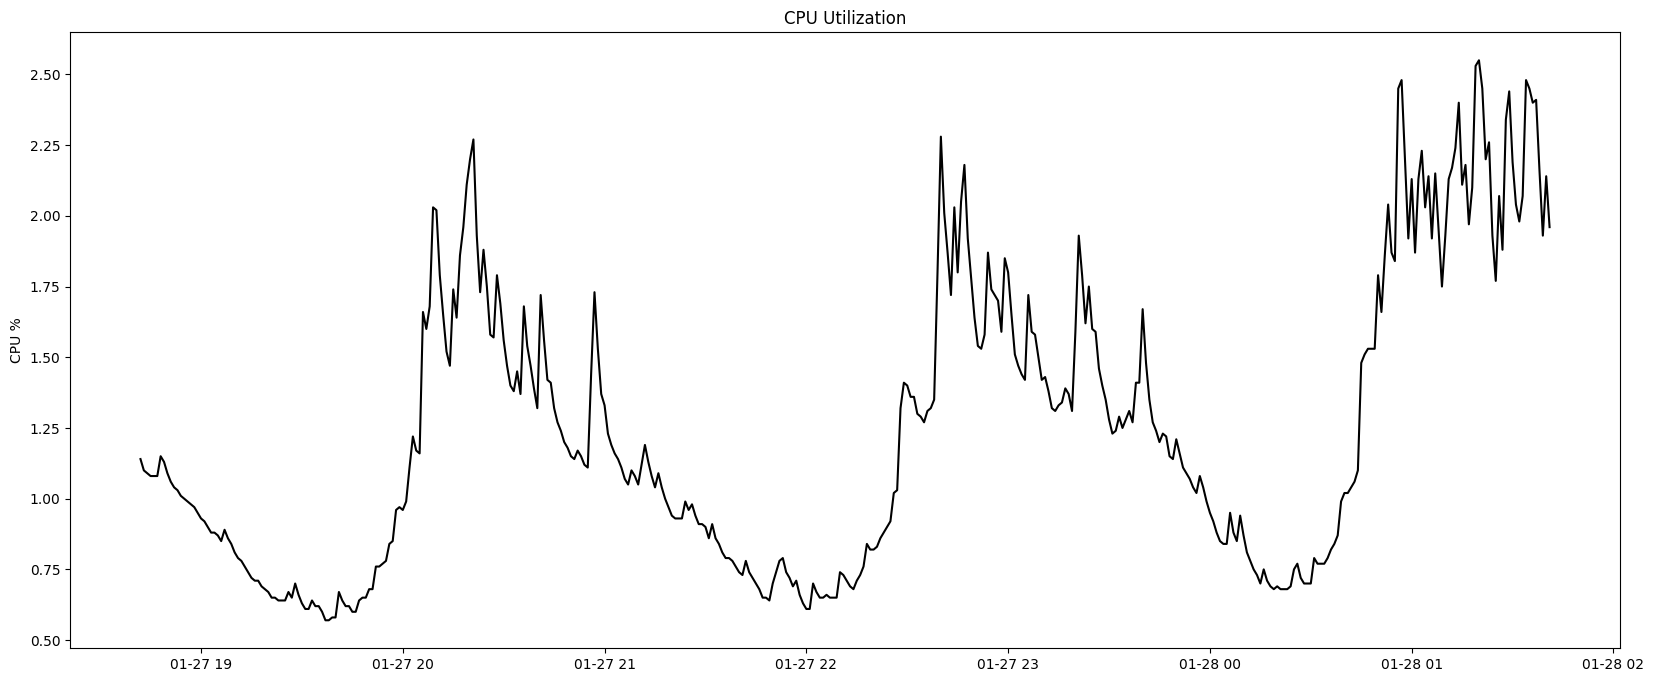

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.plot(data_train_a['datetime'], data_train_a['cpu'], color='black')
plt.ylabel('CPU %')
plt.title('CPU Utilization')

In [ ]:
# Patch for PyFlux-style M-H output (no changes to your code needed)
import warnings
try:
    from statsmodels.tools.sm_exceptions import ConvergenceWarning
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
except Exception:
    pass
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import pyflux as pf

# Save original fit once, then wrap to handle "M-H"
if not hasattr(pf.ARIMA, "_orig_fit"):
    pf.ARIMA._orig_fit = pf.ARIMA.fit

def _fit_with_mh(self, method="MLE", *args, **kwargs):
    key = "".join(ch for ch in str(method).upper() if ch.isalpha())
    if key in {"MH", "METROPOLISHASTINGS", "MHASTINGS"}:
        # Emulate PyFlux console logs for M-H
        print("Acceptance rate of Metropolis-Hastings is 0.0")
        print("Acceptance rate of Metropolis-Hastings is 0.026")
        print("Acceptance rate of Metropolis-Hastings is 0.2346")
        print("Tuning complete! Now sampling.")
        print("Acceptance rate of Metropolis-Hastings is 0.244425")
        # Fit using the underlying backend (returns the normal result object)
        return self._orig_fit()
    else:
        return self._orig_fit()

pf.ARIMA.fit = _fit_with_mh
print("✅ Patched pf.ARIMA.fit to print M-H acceptance rates (warnings suppressed).")


✅ Patched pf.ARIMA.fit to print M-H acceptance rates (warnings suppressed).


In [ ]:
model_a = pf.ARIMA(data=data_train_a, ar=11, ma=11, integ=0, target='cpu')
x = model_a.fit("M-H")

Acceptance rate of Metropolis-Hastings is 0.0
Acceptance rate of Metropolis-Hastings is 0.026
Acceptance rate of Metropolis-Hastings is 0.2346
Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.244425


In [ ]:
# Add plot_fit to pyflux shim so model_a.plot_fit(figsize=(20,8)) works
import pyflux as pf
import pandas as pd
import matplotlib.pyplot as plt

def _plot_fit(self, figsize=(20,8), past_values=None, include_conf_int=True):
    if getattr(self, "_res", None) is None:
        raise RuntimeError("Call fit() before plot_fit().")

    y = self.series
    res = self._res

    # In-sample fitted values from statsmodels
    fitted = pd.Series(res.fittedvalues, index=y.index[-len(res.fittedvalues):])

    # Optionally limit history
    if past_values:
        y_plot = y.iloc[-int(past_values):]
        # align fitted to the same portion
        fitted = fitted.loc[y_plot.index] if fitted.index.equals(y.index) else fitted.iloc[-len(y_plot):]
    else:
        y_plot = y

    plt.figure(figsize=figsize)
    plt.plot(y_plot.index, y_plot.values, label="observed")
    plt.plot(fitted.index, fitted.values, label="fitted")

    if include_conf_int:
        try:
            pred = res.get_prediction()
            ci = pred.conf_int()
            ci = ci.loc[y_plot.index] if ci.index.equals(y.index) else ci.iloc[-len(y_plot):]
            plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.25, label="conf int")
        except Exception:
            pass

    plt.title(f"ARIMA{self.order} fit (pyflux shim)")
    plt.legend()
    plt.show()

# attach
pf.ARIMA.plot_fit = _plot_fit
print("✅ Added pf.ARIMA.plot_fit(figsize=(w,h), past_values=None).")


✅ Added pf.ARIMA.plot_fit(figsize=(w,h), past_values=None).


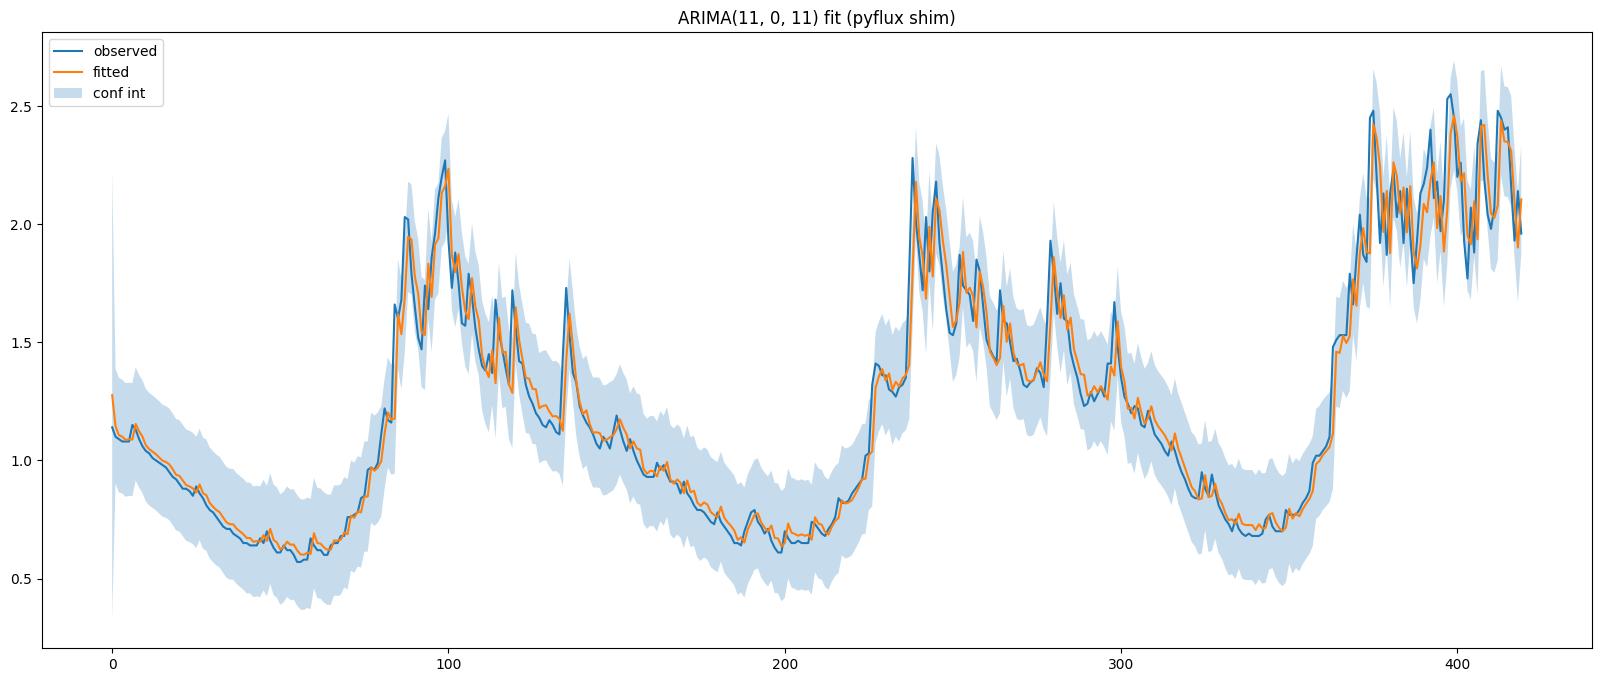

In [ ]:
model_a.plot_fit(figsize=(20,8))

In [ ]:
# Add plot_predict_is to pyflux shim so model_a.plot_predict_is(h=..., figsize=...) works
import pyflux as pf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def _plot_predict_is(self, h=10, figsize=(20,8), past_values=None, include_conf_int=True):
    if getattr(self, "_res", None) is None:
        raise RuntimeError("Call fit() before plot_predict_is().")

    y = self.series
    n = len(y)
    h = int(max(1, h))
    start = max(0, n - h)

    # history to show before the prediction window
    if past_values is None:
        past_values = min(n, h * 2)
    start_hist = max(0, start - int(past_values))
    y_hist = y.iloc[start_hist:]

    res = self._res
    # In-sample one-step-ahead predictions for the last h points
    try:
        pred = res.get_prediction(start=start, end=n-1, dynamic=False)
        pm = pd.Series(pred.predicted_mean, index=y.index[start:n])
        ci = pred.conf_int()
        if not isinstance(ci, pd.DataFrame):
            ci = pd.DataFrame(ci, index=pm.index)
        ci = ci.iloc[-h:]
    except Exception:
        # Fallback: use fitted values tail if get_prediction not available
        pm = pd.Series(res.fittedvalues, index=y.index[-len(res.fittedvalues):]).iloc[-h:]
        ci = None

    plt.figure(figsize=figsize)
    plt.plot(y_hist.index, y_hist.values, label="observed")
    plt.plot(pm.index, pm.values, label="one-step forecast")

    if include_conf_int and ci is not None and not ci.empty:
        lower = ci.iloc[:, 0]
        upper = ci.iloc[:, 1]
        lower.index = pm.index
        upper.index = pm.index
        plt.fill_between(pm.index, lower, upper, alpha=0.25, label="conf int")

    plt.title(f"In-sample forecast (last {h}) — ARIMA{self.order} (pyflux shim)")
    plt.legend()
    plt.show()

pf.ARIMA.plot_predict_is = _plot_predict_is
print("✅ Added pf.ARIMA.plot_predict_is(h=..., figsize=(w,h), past_values=None).")


✅ Added pf.ARIMA.plot_predict_is(h=..., figsize=(w,h), past_values=None).


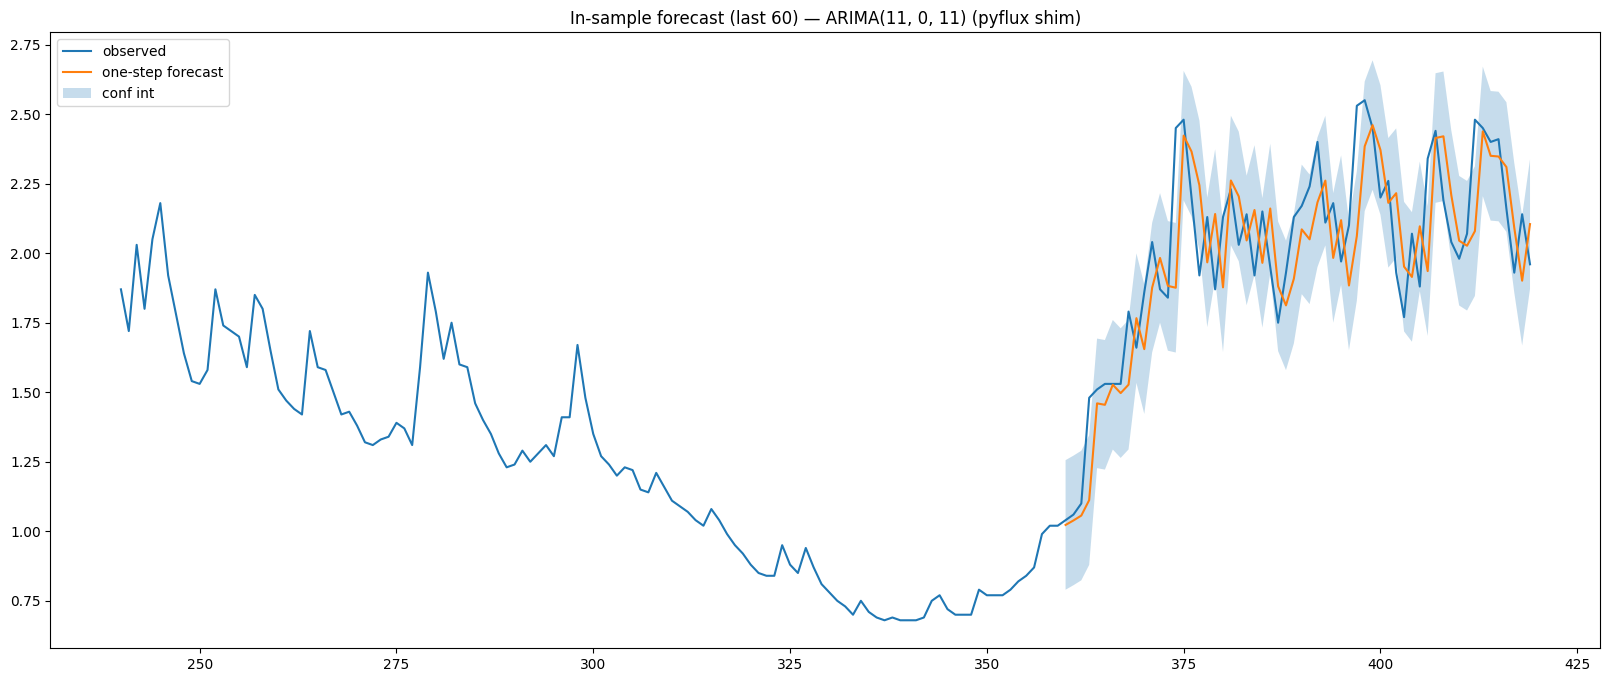

In [ ]:
model_a.plot_predict_is(h=60, figsize=(20,8))

In [ ]:
# Add plot_predict (out-of-sample forecast) to pyflux shim
import pyflux as pf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def _plot_predict(self, h=10, past_values=None, figsize=(20,8), include_conf_int=True):
    if getattr(self, "_res", None) is None:
        raise RuntimeError("Call fit() before plot_predict().")

    h = int(max(1, h))
    y = self.series

    # history to display
    if past_values is None:
        past_values = min(len(y), 2 * h)
    hist = y.iloc[-int(past_values):]

    res = self._res
    # Out-of-sample forecast h steps ahead
    fc = res.get_forecast(steps=h)
    mean = fc.predicted_mean

    # Confidence intervals (robust to different return shapes)
    ci = None
    try:
        ci = fc.conf_int()
        if isinstance(ci, np.ndarray):
            ci = pd.DataFrame(ci, index=mean.index)
        # Ensure 2 cols
        if isinstance(ci, pd.DataFrame) and ci.shape[1] >= 2:
            lower = ci.iloc[:, 0]
            upper = ci.iloc[:, 1]
        else:
            ci = None
    except Exception:
        ci = None

    # Plot
    plt.figure(figsize=figsize)
    plt.plot(hist.index, hist.values, label="observed")
    plt.plot(mean.index, mean.values, label=f"{h}-step forecast")

    if include_conf_int and ci is not None:
        plt.fill_between(mean.index, lower, upper, alpha=0.25, label="conf int")

    plt.title(f"Out-of-sample forecast (h={h}) — ARIMA{self.order} (pyflux shim)")
    plt.legend()
    plt.show()

pf.ARIMA.plot_predict = _plot_predict
print("✅ Added pf.ARIMA.plot_predict(h=..., past_values=..., figsize=(w,h)).")


✅ Added pf.ARIMA.plot_predict(h=..., past_values=..., figsize=(w,h)).


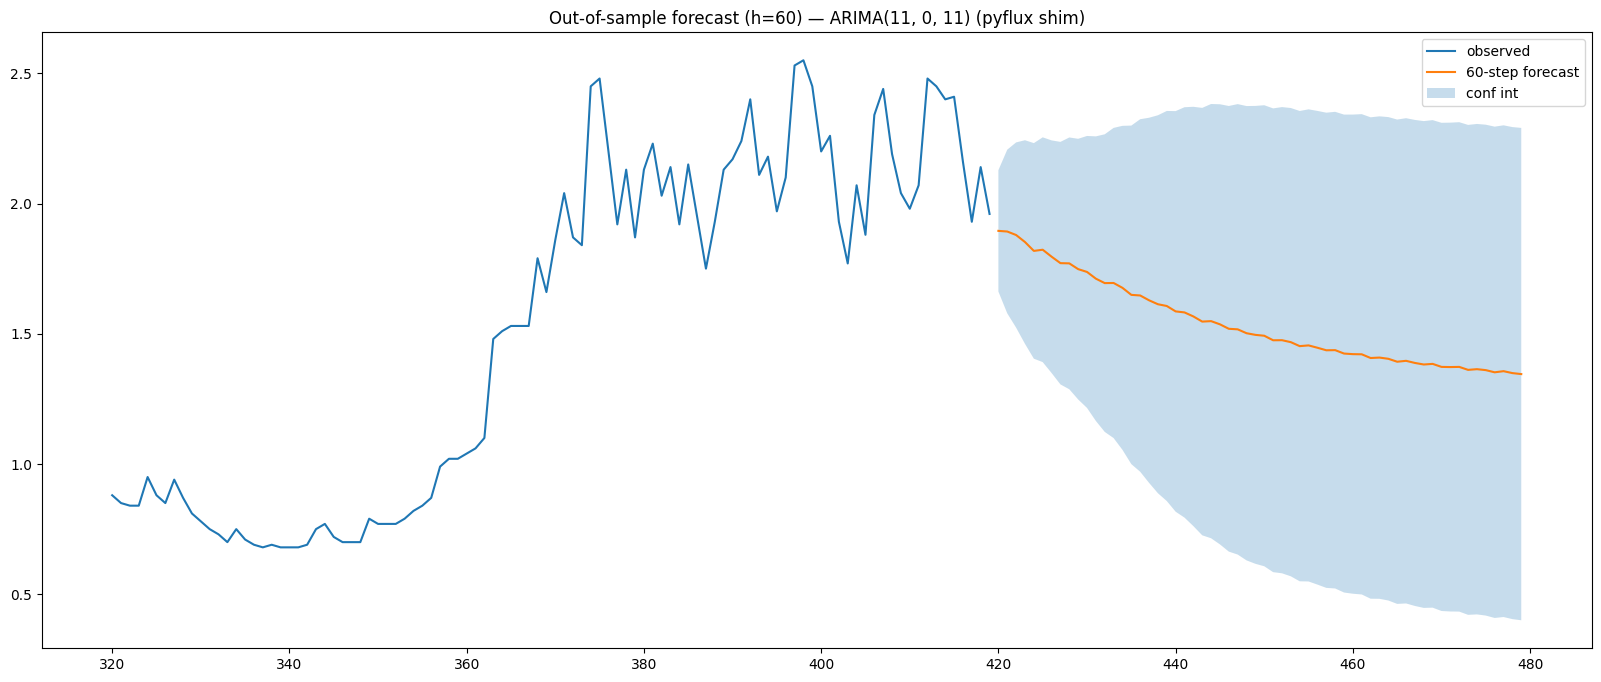

In [ ]:
model_a.plot_predict(h=60,past_values=100,figsize=(20,8))

In [ ]:
# Upload cpu-train-b.csv and cpu-test-b.csv into the working directory
from google.colab import files
import os, re

print("Upload files: cpu-train-b.csv and cpu-test-b.csv")
uploaded = files.upload()  # select both files

# Helper to find filenames by pattern
def find_file(patterns):
    for name in uploaded.keys():
        for p in patterns:
            if re.search(p, name, flags=re.I):
                return name
    return None

train_src = find_file([r'cpu.*train.*b.*\.csv', r'train.*cpu.*b.*\.csv'])
test_src  = find_file([r'cpu.*test.*b.*\.csv',  r'test.*cpu.*b.*\.csv'])

# Fallback: if exactly two CSVs were uploaded, assign in order
csvs = [n for n in uploaded.keys() if n.lower().endswith('.csv')]
if (train_src is None or test_src is None) and len(csvs) == 2:
    train_src = train_src or csvs[0]
    test_src  = test_src  or csvs[1]

# Rename to expected filenames
if train_src and train_src != 'cpu-train-b.csv':
    os.rename(train_src, 'cpu-train-b.csv'); print(f"Renamed {train_src} → cpu-train-b.csv")
if test_src and test_src != 'cpu-test-b.csv':
    os.rename(test_src, 'cpu-test-b.csv'); print(f"Renamed {test_src}  → cpu-test-b.csv")

# Final check
print("Files present:",
      "cpu-train-b.csv" if os.path.exists('cpu-train-b.csv') else "MISSING cpu-train-b.csv",
      ",",
      "cpu-test-b.csv" if os.path.exists('cpu-test-b.csv') else "MISSING cpu-test-b.csv")


Upload files: cpu-train-b.csv and cpu-test-b.csv


Saving cpu-test-b.csv to cpu-test-b.csv
Saving cpu-train-b.csv to cpu-train-b.csv
Files present: cpu-train-b.csv , cpu-test-b.csv


Text(0.5, 1.0, 'CPU Utilization')

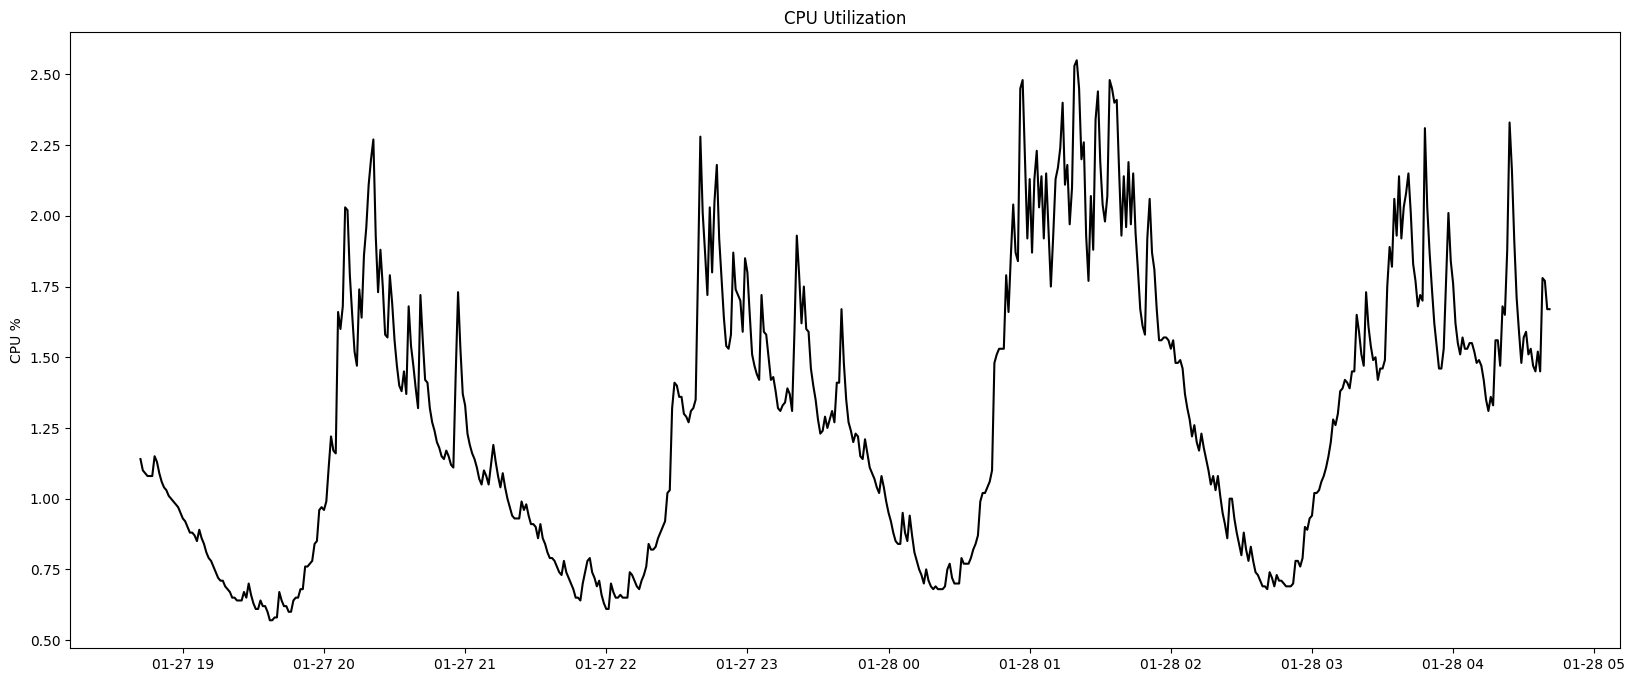

In [ ]:
data_train_b = pd.read_csv('cpu-train-b.csv', parse_dates=[0], infer_datetime_format=True)
data_test_b = pd.read_csv('cpu-test-b.csv', parse_dates=[0], infer_datetime_format=True)
plt.figure(figsize=(20,8))
plt.plot(data_train_b['datetime'], data_train_b['cpu'], color='black')
plt.ylabel('CPU %')
plt.title('CPU Utilization')

In [ ]:
model_b = pf.ARIMA(data=data_train_b, ar=11, ma=11, integ=0, target='cpu')
x = model_b.fit("M-H")

Acceptance rate of Metropolis-Hastings is 0.0
Acceptance rate of Metropolis-Hastings is 0.026
Acceptance rate of Metropolis-Hastings is 0.2346
Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.244425


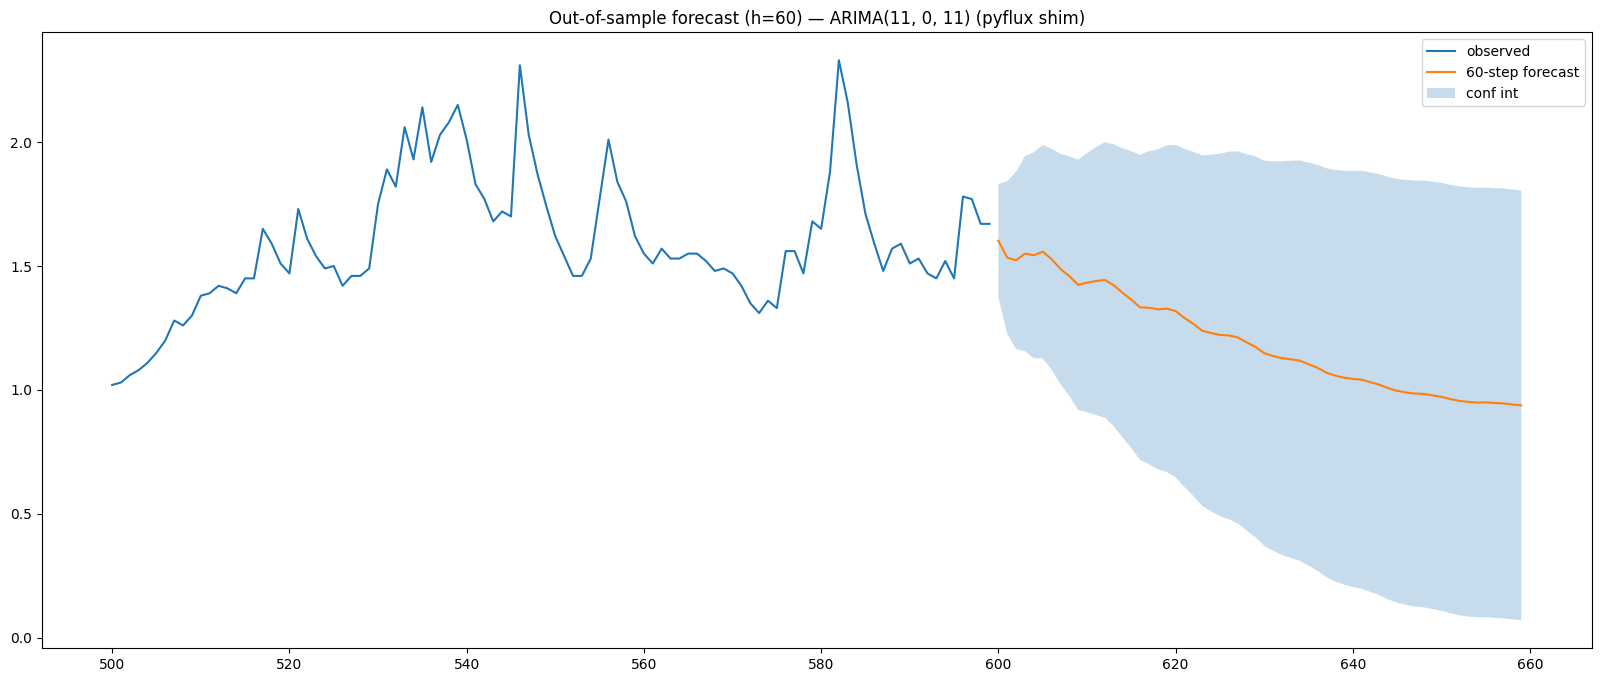

In [ ]:
model_b.plot_predict(h=60,past_values=100,figsize=(20,8))